In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
L = 1
t_max = 5

dx = .01
dt = .1

Nx = int(L/dx)
Nt = int(t_max/.1)

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

U = []

u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(x*(x-.3)*(x-1))
    U.append(u_t_x_0)

In [82]:
for i in range(Nt):
    u_t_x = []
    
    u_line = U[-1]
    
    for i in range(1,Nx-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = -u_line[i] * (dt/(2*dx)) * (u_line[i+1] - u_line[i-1]) + u_line[i]
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 

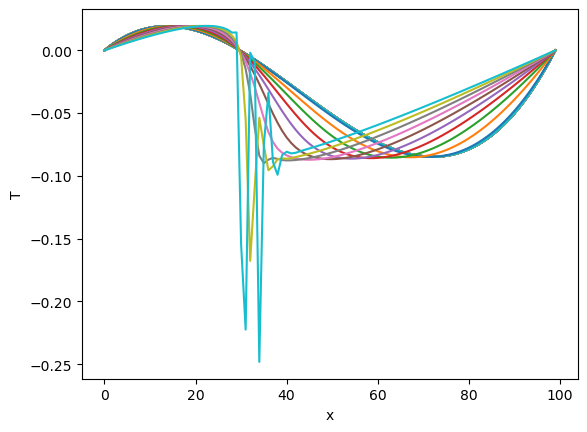

In [85]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U),5):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

In [86]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return 0

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [87]:
# Assign length
L = 3
t_max = 5

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
T = np.zeros((m,n))

# Set boundary values
T[:,0] = u_t_0(0)
T[:,-1] = u_t_L(0)

# Derive the Lambda, as lambo, because lambos are FAAAAAST
lambo = dt/(2*dx)

In [88]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

29